In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

2024-03-21 14:22:14.842313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 14:22:14.842434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 14:22:14.972268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
df_org= pd.read_excel("/kaggle/input/testdataset/refined_3_class_dataset.xlsx")

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,Lyricist,Individual's Song ID,Verse,Label
3106,Moniruzzaman Monir,song1,না না কইমু বেয়াদবী করমু না বুবুর মনে কষ্ট দিলে...,2
6161,Sonjib Chowdhury,song3,কার ছবি নেই কেউ কি ছিলো এই ভেবে ডুবে গেছে রাত ...,3
1867,Kazi Nazrul Islam,song377,শিরাজের নওরোজে ফাল্গুন মাসে যেন তার প্রিয়ার স...,2
3238,Mukul Dutta,song9,আলোর পরশে ভোর হয়ে যাবে এই রাত কোনদিন ভুলে ছেড়ো...,2
5509,Rabindra Nath Tagore,song790,"বনপথ হতে, সুন্দরী, এনেছি মল্লিকামঞ্জলী তুমি লব...",3


In [4]:
labels = df_org['Label'].unique().tolist()
# labels = [s.strip() for s in labels ]
labels

[2, 3, 1]

In [5]:
for key, value in enumerate(labels):
    print(value)

2
3
1


In [6]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [7]:
label2id

{2: 0, 3: 1, 1: 2}

In [8]:
id2label

{0: 2, 1: 3, 2: 1}

In [9]:
df_org.head()

,Lyricist,Individual's Song ID,Verse,Label
3106,Moniruzzaman Monir,song1,না না কইমু বেয়াদবী করমু না বুবুর মনে কষ্ট দিলে...,2
6161,Sonjib Chowdhury,song3,কার ছবি নেই কেউ কি ছিলো এই ভেবে ডুবে গেছে রাত ...,3
1867,Kazi Nazrul Islam,song377,শিরাজের নওরোজে ফাল্গুন মাসে যেন তার প্রিয়ার স...,2
3238,Mukul Dutta,song9,আলোর পরশে ভোর হয়ে যাবে এই রাত কোনদিন ভুলে ছেড়ো...,2
5509,Rabindra Nath Tagore,song790,"বনপথ হতে, সুন্দরী, এনেছি মল্লিকামঞ্জলী তুমি লব...",3


In [10]:
df_org["labels"]=df_org.Label.map(lambda x: label2id[x])

In [11]:
df_org.head(30)

,Lyricist,Individual's Song ID,Verse,Label,labels
3106,Moniruzzaman Monir,song1,না না কইমু বেয়াদবী করমু না বুবুর মনে কষ্ট দিলে...,2,0
6161,Sonjib Chowdhury,song3,কার ছবি নেই কেউ কি ছিলো এই ভেবে ডুবে গেছে রাত ...,3,1
1867,Kazi Nazrul Islam,song377,শিরাজের নওরোজে ফাল্গুন মাসে যেন তার প্রিয়ার স...,2,0
3238,Mukul Dutta,song9,আলোর পরশে ভোর হয়ে যাবে এই রাত কোনদিন ভুলে ছেড়ো...,2,0
5509,Rabindra Nath Tagore,song790,"বনপথ হতে, সুন্দরী, এনেছি মল্লিকামঞ্জলী তুমি লব...",3,1
6167,Sonjib Chowdhury,song4,তবে এই হোক তীরে জাগুক প্লাবন দিন হোক লাবন্য হৃ...,2,0
2142,Kazi Nazrul Islam,song508,কথার কুসুমে গাঁথা গানের মালিকা কার। ভেসে এসে হ...,1,2
2457,Khan Ataur Rahaman,song11,সাগর সেঁচে খোঁজেনি সে হিরামতির মালা কুঁড়ে ঘরে ...,3,1
6047,Shylen Roy,song4,আমায় মালা করে গলে নাইবা রাখিলে রাখো শ্রীচরণতলে...,2,0
3244,Nasir Uddin Khan,song2,যত আশা ছিল মনে সবই ভুলে যাই তবু তুমি সুখী হও এ...,2,0


<Axes: ylabel='count'>

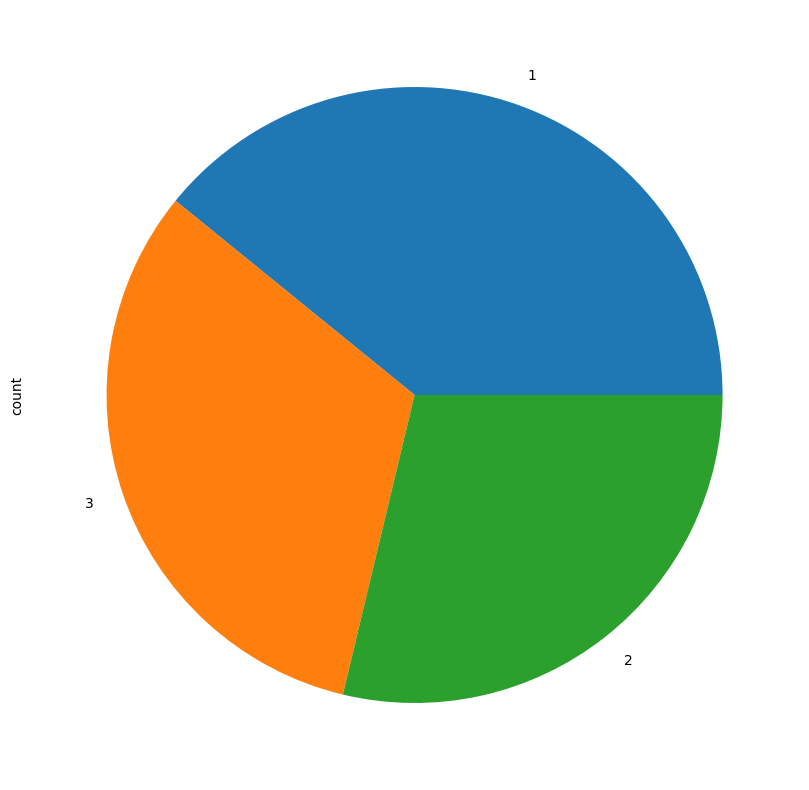

In [12]:
df_org.Label	.value_counts().plot(kind='pie', figsize=(10,10))

In [13]:
tokenizer = BertTokenizerFast.from_pretrained("sagorsarker/bangla-bert-base", max_length=512)

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [14]:
model = BertForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [15]:
SIZE= df_org.shape[0]

train_texts= list(df_org.Verse[:SIZE//2])

val_texts=   list(df_org.Verse[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.Verse[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [16]:
len(train_texts)

3250

In [17]:
len(train_texts), len(val_texts), len(test_texts)

(3250, 1625, 1625)

In [18]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [19]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [20]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [21]:
from transformers import TrainingArguments, Trainer

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [23]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='/kaggle/working/TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./kaggle/working/multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

In [24]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [25]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.083000,1.043179,0.443077,0.349111,0.460209,0.399411
100,1.044300,0.988072,0.511385,0.401533,0.561437,0.479059
150,0.982500,0.902251,0.600615,0.590196,0.594222,0.592388
200,0.880100,0.972974,0.573538,0.528212,0.645303,0.539707
250,0.697200,0.828160,0.648615,0.636590,0.646853,0.636688
300,0.664500,0.896354,0.646154,0.646276,0.662474,0.655759
350,0.633100,0.807878,0.672615,0.666626,0.669898,0.667045
400,0.592300,0.828620,0.654769,0.642801,0.653107,0.643091
450,0.386000,0.999562,0.652308,0.646799,0.655030,0.651368
500,0.251000,0.983546,0.672615,0.662211,0.679164,0.659074


TrainOutput(global_step=612, training_loss=0.6481714825225032, metrics={'train_runtime': 733.9489, 'train_samples_per_second': 13.284, 'train_steps_per_second': 0.834, 'total_flos': 2084351606064000.0, 'train_loss': 0.6481714825225032, 'epoch': 3.0})

In [27]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.232144,0.922462,0.920905,0.929763,0.916400
val,0.983546,0.672615,0.662211,0.679164,0.659074
test,1.027107,0.665231,0.651611,0.674849,0.647667


In [28]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [29]:
# Test with a an example text in Turkish
text = "আমার ব্যথাগুলো আমারই থাক অশ্রুতে দুটি চোখ যায় ভরে যাক।"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.9923, 0.0019, 0.0058]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 2)

In [30]:
model_path = "/kaggle/working/verse-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


('/kaggle/working/verse-text-classification-model/tokenizer_config.json',
 '/kaggle/working/verse-text-classification-model/special_tokens_map.json',
 '/kaggle/working/verse-text-classification-model/vocab.txt',
 '/kaggle/working/verse-text-classification-model/added_tokens.json',
 '/kaggle/working/verse-text-classification-model/tokenizer.json')

In [31]:
model_path = "/kaggle/working/verse-text-classification-model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [34]:
nlp("কইতো যাহা আমার দাদায়, কইছে তাহা আমার বাবায় ।। এখন কও দেহি ভাই মোর মুখে কি অন্য কথা শোভা পায় কও দেহি ভাই এখন কও দেহি ভাই মোর মুখে কি অন্য কথা শোভা পায় ওরা আমার মুখের ভাষা কাইরা নিতে চায় ।।ে")

[{'label': 3, 'score': 0.5532130002975464}]